In [16]:
# Import necessary libraries
# - `geopandas` for geographic data manipulation
# - `matplotlib.pyplot` for visualization
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
# Load the Business Improvement Districts (BIDs) dataset
# `bid_data` includes geographic boundaries of BIDs across NYC.
bid_data = gpd.read_file('../common_files/NYC_BIDS_09112015.csv', encoding='utf-8')

In [18]:
bid_data.head()

,the_geom,Id,OBJECTID_1,OBJECTID_2,Shape_Leng,F_ALL_BIDs,F_ALL_BI_1,F_ALL_BI_2,F_ALL_BI_3,F_ALL_BI_4,F_ALL_BI_6,F_ALL_BI_7,Shape_Le_1,Shape_Ar_1,Year_Found,Shape_Area
0,MULTIPOLYGON (((-73.94296015325146 40.73949166...,0,0,0,0,0,Queens,Long Island City Partnership,0,https://www.longislandcityqueens.com/,0,0,0,0,2005,0
1,MULTIPOLYGON (((-73.89166191549769 40.67759930...,0,0,0,0,0,Brooklyn,Cypress Hills Fulton,0,https://cypresshillsfultonbid.org/,0,0,0,0,2023,0
2,MULTIPOLYGON (((-73.98282323348212 40.73130538...,0,0,1,0,0,Manhattan,Union Square Partnership,892,https://www.unionsquarenyc.org/,3400000,3950623,25744.4695903,1275270.53685,1984,206555.808776
3,MULTIPOLYGON (((-73.9419337956347 40.806137014...,0,0,2,0,0,Manhattan,125th Street,220,https://www.125thstreet.nyc/,1240462,1289475,18167.7930477,982675.507591,1994,159516.90573
4,MULTIPOLYGON (((-73.9188925538744 40.825078988...,0,0,3,0,1,Bronx,161st Street,145,http://www.161bid.com/,1687028,506873,16588.0134708,1303742.08624,2005,211748.007845


In [19]:
# Load the sidewalk dataset
# `sidewalk_data` contains geographic locations of sidewalks across NYC.
sidewalk_data = gpd.read_file('./files/NYC_Planimetric_Database__Sidewalk_20250228.csv', encoding='utf-8')

In [20]:
# load geojson file
kpfui_dev_data = gpd.read_file('./files/kpfui_dev.json')

In [21]:
sidewalk_gdf = gpd.GeoDataFrame(
    sidewalk_data, 
    geometry=gpd.GeoSeries.from_wkt(sidewalk_data['the_geom'])
)

In [22]:
bid_gdf = gpd.GeoDataFrame(
    bid_data,
    geometry=gpd.GeoSeries.from_wkt(bid_data['the_geom']),
)

In [23]:
# Filter for West Village BID
wv_bid = bid_gdf[bid_gdf['F_ALL_BI_2'] == 'West Village']
# Use `explode` to ensure each geometry component is in a separate row, simplifying spatial analysis
exploded_wv_data = wv_bid.explode()

In [24]:
# Similarly explode the sidewalk MultiPolygons
exploded_sidewalk_data = sidewalk_gdf.explode(index_parts=True)

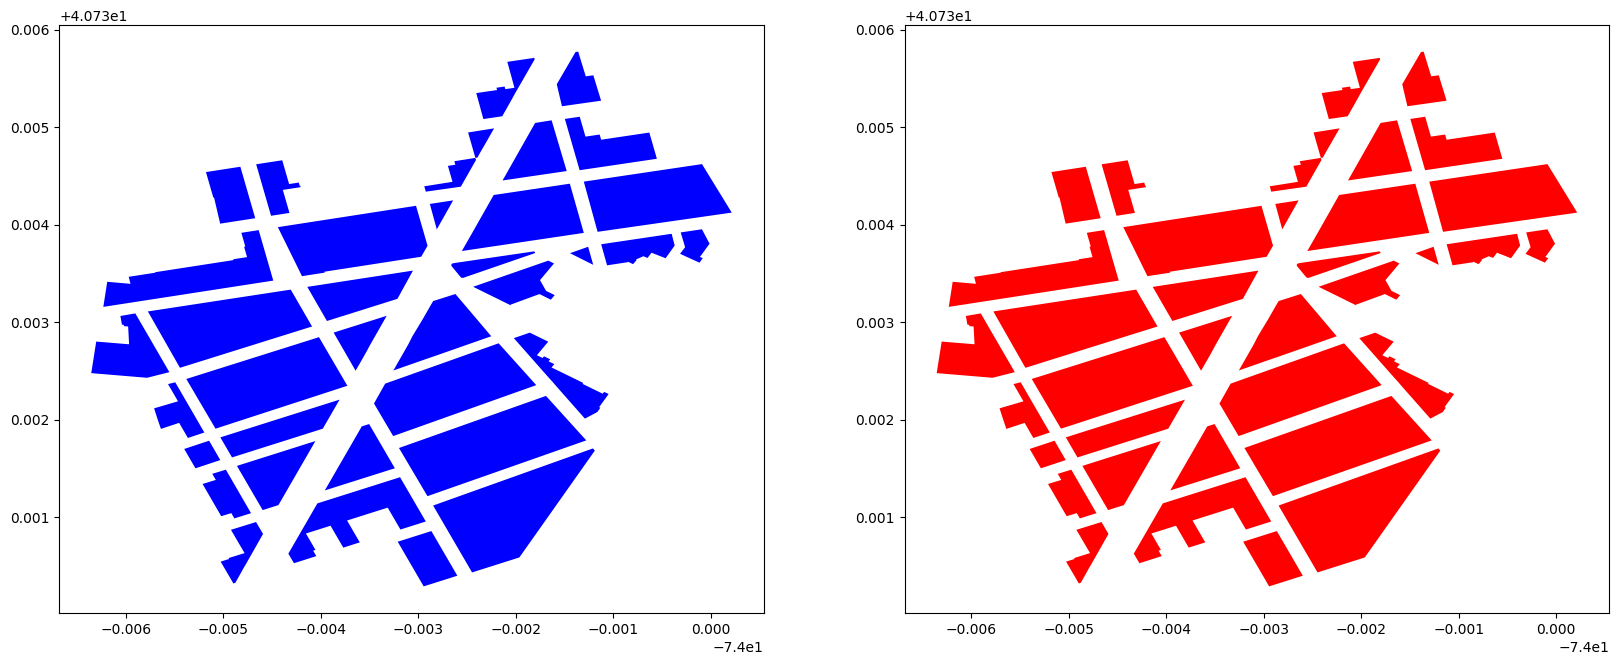

In [25]:
# plot the two datasets side by side
fig, ax = plt.subplots(1, 2,  figsize=(20, 10))

# plot the bid_data_objectid_2_0 geodataframe
wv_bid.plot(ax=ax[0], color='blue', markersize=.01)
# plot the exploded geodataframe
exploded_wv_data.plot(ax=ax[1], color='red', markersize=.01)
exploded_wv_data.set_crs(epsg=4326, inplace=True)
plt.show()

In [26]:
# Create a buffered version of the BID boundaries
# Buffer distance in degrees (for EPSG:4326) - adjust as needed
# ~0.0001 degrees is roughly 10-11 meters at NYC's latitude
buffer_distance = 0.0002 
buffered_wv_data = exploded_wv_data.copy()
buffered_wv_data['geometry'] = exploded_wv_data.geometry.buffer(buffer_distance)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23184\3212709067.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_wv_data['geometry'] = exploded_wv_data.geometry.buffer(buffer_distance)


In [27]:
# Spatial join directly without bbox filtering
sidewalks_within_bbox = gpd.sjoin(
    exploded_sidewalk_data, 
    buffered_wv_data, 
    how='inner', 
    predicate='intersects'
)

print("Number of sidewalks found:", len(sidewalks_within_bbox))

Number of sidewalks found: 216


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23184\1289927893.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  sidewalks_within_bbox = gpd.sjoin(


In [28]:
# Spatial join directly without bbox filtering
kpfui_dev_within_bbox = gpd.sjoin(
    kpfui_dev_data, 
    buffered_wv_data, 
    how='inner', 
    predicate='intersects'
)
print("Number of sidewalks found:", len(kpfui_dev_within_bbox))

Number of sidewalks found: 665


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23184\2471821290.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


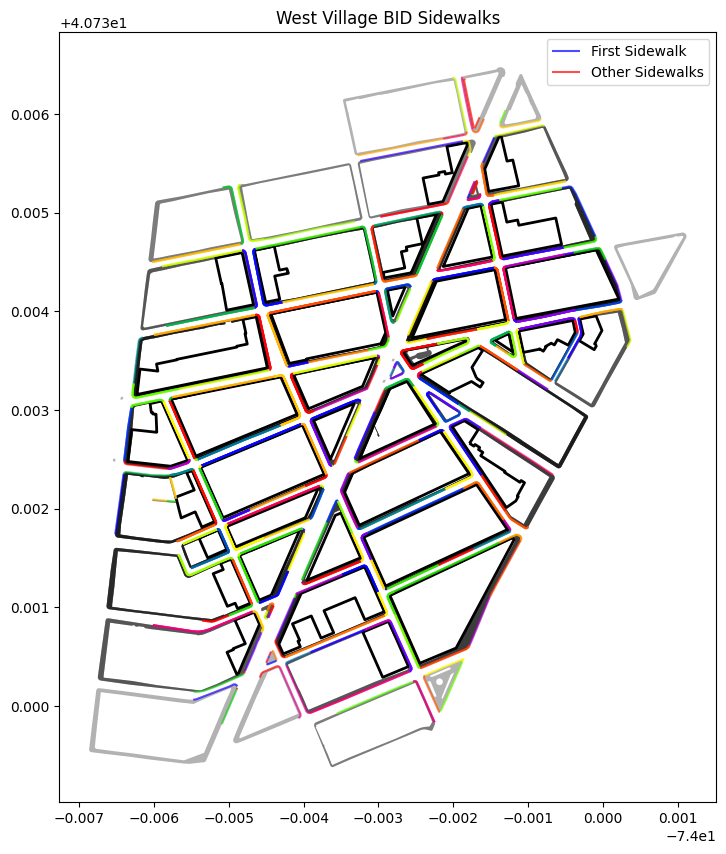

In [38]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the BID boundary
wv_bid.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='BID Boundary')

# Plot the sidewalks
sidewalks_within_bbox.plot(ax=ax, color='black', alpha=0.3, label='Sidewalks')

# Split the sidewalks dataframe into first row and rest
if len(kpfui_dev_within_bbox) > 0:
    first_row = kpfui_dev_within_bbox.iloc[[0]]
    rest_rows = kpfui_dev_within_bbox.iloc[1:] if len(kpfui_dev_within_bbox) > 1 else None
    
    # Plot the first row in blue
    first_row.plot(ax=ax, color='blue', alpha=0.7, label='First Sidewalk')
    
    # Plot the rest in red (if there are any)
    if rest_rows is not None and len(rest_rows) > 0:
        rest_rows.plot(ax=ax, alpha=0.7, label='Other Sidewalks', cmap='prism')
else:
    print("No sidewalks found to plot")

# Add labels and title
plt.title('West Village BID Sidewalks')
plt.legend()

# Show the plot
plt.show()

In [30]:
# Save the processed sidewalk data as GeoJSON
kpfui_dev_within_bbox.to_file("./files/kpfui_dev_within_bbox.json", driver='GeoJSON')

# Save the BID boundary as GeoJSON
wv_bid.to_file("./files/wv_bid.json", driver='GeoJSON')

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [31]:
# Get and display all column names
kpfui_dev_within_bbox.columns

Index(['area', 'p_total_9', 'area_p_9', 'p_walk_9', 'p_queue_9', 'rest_9',
       'supe_9', 'phar_9', 'bank_9', 'offi_9', 'subw_9', 'p_total_12',
       'area_p_12', 'p_walk_12', 'p_queue_12', 'rest_12', 'supe_12', 'phar_12',
       'bank_12', 'offi_12', 'subw_12', 'p_total_19', 'area_p_19', 'p_walk_19',
       'p_queue_19', 'rest_19', 'supe_19', 'phar_19', 'bank_19', 'offi_19',
       'subw_19', 'geometry', 'index_right', 'the_geom', 'Id', 'OBJECTID_1',
       'OBJECTID_2', 'Shape_Leng', 'F_ALL_BIDs', 'F_ALL_BI_1', 'F_ALL_BI_2',
       'F_ALL_BI_3', 'F_ALL_BI_4', 'F_ALL_BI_6', 'F_ALL_BI_7', 'Shape_Le_1',
       'Shape_Ar_1', 'Year_Found', 'Shape_Area'],
      dtype='object')

In [32]:
kpfui_dev_within_bbox.head(1)["geometry"]

1016    LINESTRING (-74.00436 40.73046, -74.00437 40.7...
Name: geometry, dtype: geometry

In [51]:
# First, ensure both datasets have the same CRS
# Set CRS for sidewalks if it's None
if sidewalks_within_bbox.crs is None:
    sidewalks_within_bbox.set_crs(epsg=4326, inplace=True)

# Make sure kpfui_dev_within_bbox has the same CRS
if kpfui_dev_within_bbox.crs != sidewalks_within_bbox.crs:
    kpfui_dev_within_bbox = kpfui_dev_within_bbox.to_crs(sidewalks_within_bbox.crs)

# Project to a local projected CRS for accurate distance calculations
# EPSG:2263 is NY State Plane Long Island (feet)
sidewalks_projected = sidewalks_within_bbox.to_crs(epsg=2263)
linestrings_projected = kpfui_dev_within_bbox.to_crs(epsg=2263)

print(f"Sidewalks CRS: {sidewalks_projected.crs}")
print(f"Linestrings CRS: {linestrings_projected.crs}")

Sidewalks CRS: EPSG:2263
Linestrings CRS: EPSG:2263


In [119]:
# Function to create perpendicular lines from linestring points
import numpy as np
from shapely.geometry import LineString, Point
from shapely.ops import split

def create_perpendicular_lines(linestring, length=100):
    """
    Create perpendicular lines at each vertex of the linestring.
    
    Args:
        linestring: A shapely LineString
        length: Length of the perpendicular line (in units of the CRS)
        
    Returns:
        List of perpendicular LineStrings
    """
    perp_lines = []
    coords = list(linestring.coords)
    
    for i in range(len(coords)):
        # For each point, calculate direction vector
        if i == 0:  # First point
            dx = coords[1][0] - coords[0][0]
            dy = coords[1][1] - coords[0][1]
        elif i == len(coords) - 1:  # Last point
            dx = coords[i][0] - coords[i-1][0]
            dy = coords[i][1] - coords[i-1][1]
        else:  # Middle points - average direction
            dx1 = coords[i][0] - coords[i-1][0]
            dy1 = coords[i][1] - coords[i-1][1]
            dx2 = coords[i+1][0] - coords[i][0]
            dy2 = coords[i+1][1] - coords[i][1]
            dx = (dx1 + dx2) / 2
            dy = (dy1 + dy2) / 2
        
        # Normalize the direction vector
        dist = np.sqrt(dx**2 + dy**2)
        if dist > 0:
            dx, dy = dx/dist, dy/dist
        
        # Perpendicular direction
        perpx, perpy = -dy, dx
        
        # Create perpendicular line
        x, y = coords[i]
        line = LineString([
            (x - perpx * length/2, y - perpy * length/2),
            (x + perpx * length/2, y + perpy * length/2)
        ])
        perp_lines.append(line)
    
    return perp_lines

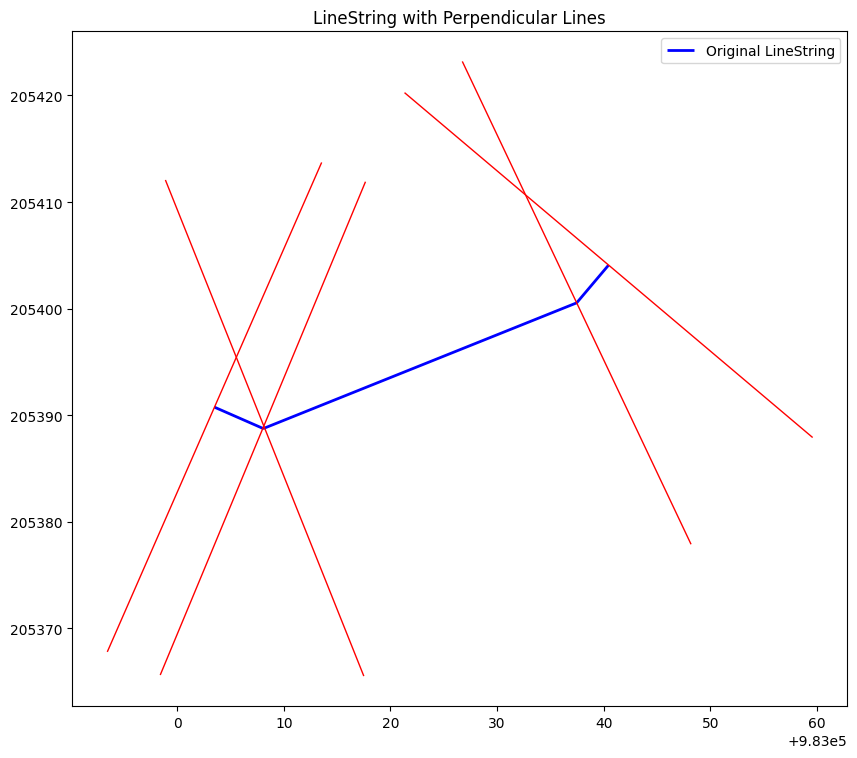

In [120]:
# Test the function on the first linestring
test_linestring = linestrings_projected.iloc[0].geometry
perp_lines = create_perpendicular_lines(test_linestring, length=50)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
linestrings_projected.iloc[[0]].plot(ax=ax, color='blue', linewidth=2, label='Original LineString')

# Plot perpendicular lines
for line in perp_lines:
    x, y = line.xy
    ax.plot(x, y, 'r-', linewidth=1)

plt.title('LineString with Perpendicular Lines')
plt.legend()
plt.show()


In [124]:
# Function to segment polygons using perpendicular lines
from shapely.ops import split

def segment_polygon_with_lines(polygon, lines):
    """
    Segment a polygon using a list of lines.
    
    Args:
        polygon: A shapely Polygon
        lines: List of shapely LineStrings
        
    Returns:
        List of segmented polygons
    """
    # Start with the original polygon
    segments = [polygon]
    
    # Split with each line
    for line in lines:
        new_segments = []
        for segment in segments:
            # Check if line intersects the segment
            if line.intersects(segment):
                try:
                    # Try to split the segment
                    split_result = split(segment, line)
                    new_segments.extend(list(split_result.geoms))
                except Exception as e:
                    # If splitting fails, keep the original segment
                    print(f"Splitting failed: {e}")
                    new_segments.append(segment)
            else:
                # If no intersection, keep the original segment
                # new_segments.append(segment)
                pass
        segments = new_segments
    
    return segments

In [125]:
# Find the nearest sidewalk polygon to each linestring
from shapely.ops import nearest_points
import geopandas as gpd

# Create a function to find the nearest sidewalk to a linestring
def find_nearest_sidewalk(linestring, sidewalks_gdf):
    """Find the nearest sidewalk polygon to a linestring"""
    # Buffer the linestring slightly to improve matching
    buffered = linestring.buffer(5)
    
    # First try to find intersecting sidewalks
    intersecting = sidewalks_gdf[sidewalks_gdf.intersects(buffered)]
    
    if len(intersecting) > 0:
        # If there are intersecting sidewalks, return the one with the largest intersection
        intersecting['intersection_area'] = intersecting.geometry.intersection(buffered).area
        return intersecting.sort_values('intersection_area', ascending=False).iloc[0]
    
    # If no intersection, find the nearest sidewalk
    distances = sidewalks_gdf.distance(linestring)
    nearest_idx = distances.idxmin()
    return sidewalks_gdf.loc[nearest_idx]

In [129]:
# Process each linestring and segment the corresponding sidewalk
results = []

for idx, row in linestrings_projected.iterrows():
    linestring = row.geometry
    
    # Find the nearest sidewalk
    nearest_sidewalk = find_nearest_sidewalk(linestring, sidewalks_projected)
    
    # Create perpendicular lines
    perp_lines = create_perpendicular_lines(linestring, length=50)
    
    # Segment the sidewalk
    segments = segment_polygon_with_lines(nearest_sidewalk.geometry, perp_lines)
    
    # Create a GeoDataFrame with the segments
    for i, segment in enumerate(segments):
        # Copy attributes from the original sidewalk
        segment_data = nearest_sidewalk.copy()
        # Add segment ID and original linestring ID
        segment_data['segment_id'] = i
        segment_data['linestring_id'] = idx
        segment_data['geometry'] = segment
        results.append(segment_data)

# Create a GeoDataFrame from the results
segmented_sidewalks = gpd.GeoDataFrame(results)


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying t

In [130]:
print("Number of linestrings:", len(linestrings_projected))
print("Number of segmented sidewalks:", len(segmented_sidewalks))
print("Number of sidewalks:", len(sidewalks_projected))

Number of linestrings: 665
Number of segmented sidewalks: 737
Number of sidewalks: 216


In [131]:
segmented_sidewalks.columns

Index(['the_geom_left', 'SOURCE_ID', 'SUB_CODE', 'FEAT_CODE', 'STATUS',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry', 'index_right', 'the_geom_right',
       'Id', 'OBJECTID_1', 'OBJECTID_2', 'Shape_Leng', 'F_ALL_BIDs',
       'F_ALL_BI_1', 'F_ALL_BI_2', 'F_ALL_BI_3', 'F_ALL_BI_4', 'F_ALL_BI_6',
       'F_ALL_BI_7', 'Shape_Le_1', 'Shape_Ar_1', 'Year_Found', 'Shape_Area',
       'intersection_area', 'segment_id', 'linestring_id'],
      dtype='object')

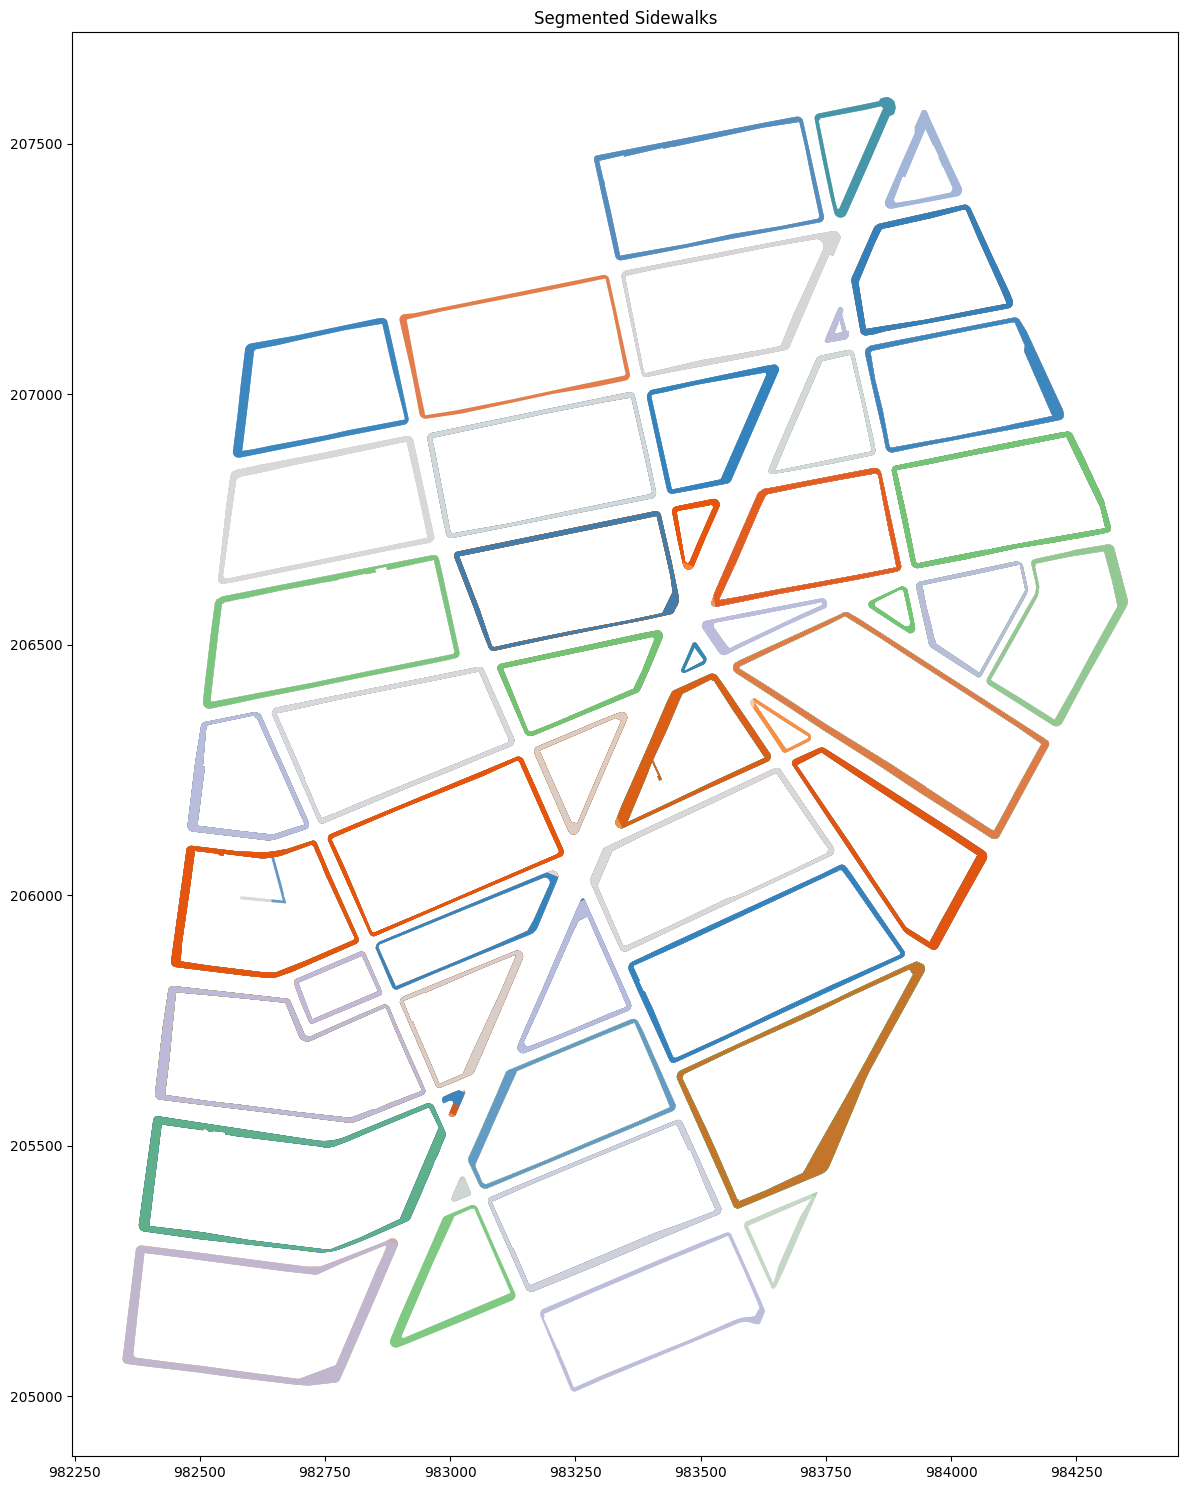

In [132]:
# Plot the segmented sidewalks with better color differentiation
fig, ax = plt.subplots(figsize=(15, 15))

# Add a color_group column to help differentiate adjacent segments
# This creates a cycling pattern of colors that helps adjacent segments look different
segmented_sidewalks['color_group'] = (segmented_sidewalks['segment_id'] % 10) + (segmented_sidewalks['linestring_id'] % 5) * 10

# Plot segmented sidewalks with a colormap that has high contrast between adjacent values
segmented_sidewalks.plot(ax=ax, column='color_group', cmap='tab20c', 
                         alpha=0.7, legend=False, label='Segmented Sidewalks')

# # Add linestrings for reference
# linestrings_projected.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)

plt.title('Segmented Sidewalks')
plt.tight_layout()
plt.show()

In [ ]:
# Save the segmented sidewalks to a GeoJSON file
segmented_sidewalks_wgs84 = segmented_sidewalks.to_crs(epsg=4326)
segmented_sidewalks_wgs84.to_file("./files/wv_bid_segmented_sidewalks.json", driver='GeoJSON')

print(f"Saved {len(segmented_sidewalks)} segmented sidewalks to GeoJSON")